# GPO2

## Faulkner-Skan Equations Using 'Formulation - B'

#### PDE:
$$
\begin{align}
f''' + \frac{(m+1)}{2}ff'' + m(1 - (f')^2) = 0
\end{align}
$$
where 
$$
\eta  = y\left ( \sqrt\frac{U(x)}{\nu x} \right )
$$
and
$$
f'(\eta ) = \frac{u}{U(x)}
$$

#### Boundary Conditions:
$$
\eta = 0 : f(0) = f'(0) = 0
$$
$$ 
 f'(-1) = 1 
$$
 #### (f'(infinity) = 1 )

### This is the implementation of the solution of Faulkner-Skan Boundary Layer Equation using the PIELM method.


#####
### For Flat Plate (m=0)

Iteration 1, Loss: 0.9867217540740967
Iteration 2, Loss: 0.9853307604789734
Iteration 3, Loss: 0.9792467951774597
Iteration 4, Loss: 0.9320688843727112
Iteration 5, Loss: 0.9318283796310425
Iteration 6, Loss: 0.9296912550926208
Iteration 7, Loss: 0.9110143184661865
Iteration 8, Loss: 0.910516083240509
Iteration 9, Loss: 0.9082890748977661
Iteration 10, Loss: 0.885698139667511
Iteration 11, Loss: 0.8847239017486572
Iteration 12, Loss: 0.8761059641838074
Iteration 13, Loss: 0.8047702312469482
Iteration 14, Loss: 0.8037478923797607
Iteration 15, Loss: 0.7991851568222046
Iteration 16, Loss: 0.7536725997924805
Iteration 17, Loss: 0.7522611021995544
Iteration 18, Loss: 0.7398125529289246
Iteration 19, Loss: 0.6405536532402039
Iteration 20, Loss: 0.6394710540771484
Iteration 21, Loss: 0.6346510648727417
Iteration 22, Loss: 0.5878539681434631
Iteration 23, Loss: 0.5870746970176697
Iteration 24, Loss: 0.5802302956581116
Iteration 25, Loss: 0.5284983515739441
Iteration 26, Loss: 0.52825593948364

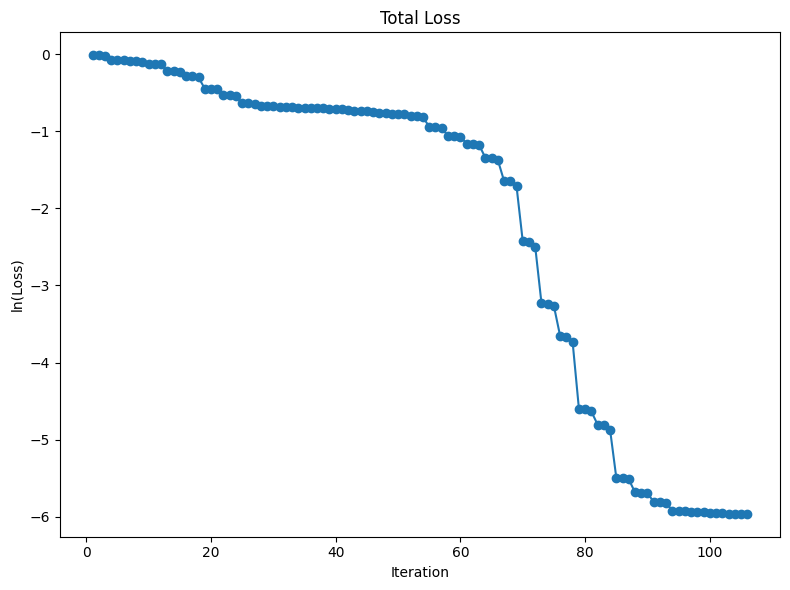

Final error: 0.0025737999476405093
Displacement Thickness (δ*): 0.2227680241620098
Momentum Thickness (θ): 1.4209073154890395
Shape Factor (H): 0.15677871577805116
Wall Skin Friction Coefficient (C_f): 1.7289391417050728


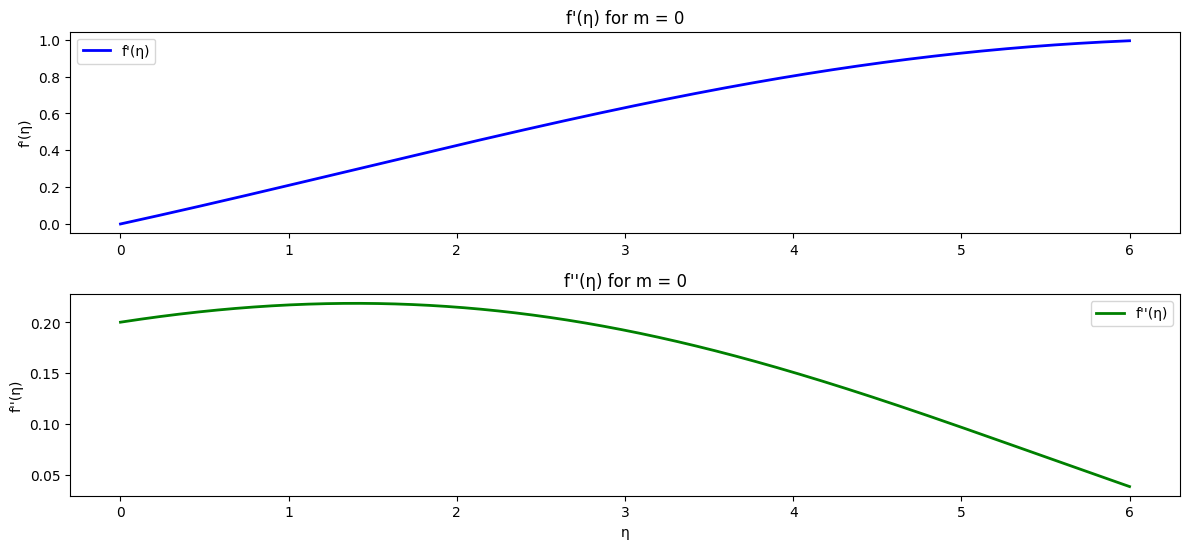

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim
import numpy as np
import matplotlib.pyplot as plt

# Creation of 1D array (representing data sampling)
np.random.seed(42)
torch.manual_seed(42)
eta = np.linspace(0, 6, 1000)[:, None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

# ODE parameters
m = 0  # this value of m can be changed and results for different wedge angles can be generated.
U_infinity = 1.0  # Free stream velocity

bc = eta[[0, -1]]
f_bc = np.array([[0], [1]])

eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

class PIELM(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1, bias=False)
        self.iter = 0
        self.Lbc = []
        self.Lpde = []

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        x = (x - eta_min) / (eta_max - eta_min)
        z = self.fc1(x)
        a = self.activation(z)
        f = self.fc2(a)
        return f

    def bc_loss(self, x, y):
        x1 = x[[0]]
        y1 = y[[0]]
        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1, g1, torch.ones([x1.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2, g2, torch.ones([x2.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        loss_bc1 = self.loss_function(f1, y1) + self.loss_function(f_etab1, torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2, y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc

    def PDE(self, x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)
        f_eta = autograd.grad(f3, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta2 = autograd.grad(f_eta, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta3 = autograd.grad(f_eta2, g3, torch.ones([g3.shape[0], 1]), create_graph=True)[0]
        pde = f_eta3 + ((m + 1) / 2) * f3 * f_eta2 + m * (1 - (f_eta)**2)
        loss_pde = self.loss_function(pde, torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde

    def loss(self, x, xb, yb):
        loss1 = self.bc_loss(xb, yb)
        loss2 = self.PDE(x)
        total_loss = abs(loss1) + abs(loss2)
        return total_loss

    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(eta, bc, f_bc)
        loss.backward()
        self.iter += 1

        # Log loss every iteration
        print(f'Iteration {self.iter}, Loss: {loss.item()}')

        return loss

    def test(self, x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_dd = autograd.grad(f_d, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()
        return pred_result, f_d, f_dd

# specification of network architecture
hidden_size = 50  # Increased hidden size

# creating an instance of NN class
pielm = PIELM()
pielm.fc1.weight.requires_grad = False
pielm.fc1.bias.requires_grad = False

# Increase max_iter for more iterations
max_iterations = 20000  # Increase this value as needed
optimizer = torch.optim.LBFGS(
    pielm.parameters(),
    lr=0.005,  # Reduced learning rate
    max_iter=max_iterations,
    tolerance_grad=1e-5,  # Increased tolerance to allow more iterations
    tolerance_change=1e-5,
    history_size=700,
    line_search_fn='strong_wolfe'
)

# Run the optimization
optimizer.step(pielm.closure)

# Print total iterations after optimization
print(f'Total iterations: {pielm.iter}')

Lbc_list = pielm.Lbc
Lpde_list = pielm.Lpde

# Plotting total loss
total_loss = [a + b for a, b in zip(Lbc_list, Lpde_list)]
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(total_loss) + 1), np.log(total_loss), marker='o')
plt.title('Total Loss')
plt.xlabel('Iteration')
plt.ylabel('ln(Loss)')
plt.tight_layout()
plt.show()

error = abs(total_loss[-1])
print(f'Final error: {error}')

# Testing the model and retrieving results
fp, fp_d, fp_dd = pielm.test(eta)

# Ensure fp is a 1D array
fp = fp.flatten()  # Flattening if it's 2D

# Calculate displacement thickness (δ*) and momentum thickness (θ)
def calculate_thicknesses(u_profile):
    # Assuming uniform free stream velocity
    y_values = np.linspace(0, 1, u_profile.shape[0])
    
    # Displacement thickness
    delta_star = np.trapz(1 - u_profile / U_infinity, y_values)
    
    # Momentum thickness
    theta = np.trapz(u_profile / U_infinity * (1 - u_profile / U_infinity), y_values)
    
    return np.abs(delta_star), np.abs(theta)

# Calculate thicknesses
delta_star, theta = calculate_thicknesses(fp)

# Calculate Shape Factor (H) and Wall Skin Friction Coefficient (C_f)
shape_factor = delta_star / theta if theta != 0 else np.inf  # Handle division by zero
C_f = 2 / (1 + shape_factor)  # Assuming u_tau / U_infinity = 1 for simplification

print(f'Displacement Thickness (δ*): {delta_star}')
print(f'Momentum Thickness (θ): {theta}')
print(f'Shape Factor (H): {shape_factor}')
print(f'Wall Skin Friction Coefficient (C_f): {C_f}')

# Creating individual plots for f, f', and f''
plt.figure(figsize=(12, 8))

# Convert eta to numpy for plotting
eta_np = eta.detach().numpy()

# Plotting f'(η)
plt.subplot(3, 1, 2)
plt.plot(eta_np, fp_d, label="f'(η)", color='blue', linewidth=2)
plt.title(f"f'(η) for m = {m}")
plt.ylabel("f'(η)")
plt.legend()

# Plotting f''(η)
plt.subplot(3, 1, 3)
plt.plot(eta_np, fp_dd, label="f''(η)", color='green', linewidth=2)
plt.title(f"f''(η) for m = {m}")
plt.ylabel("f''(η)")
plt.xlabel("η")
plt.legend()

plt.tight_layout()
plt.show()


Iteration 1, Loss: 1.9811828136444092
Iteration 2, Loss: 1.9797497987747192
Iteration 3, Loss: 1.9674869775772095
Iteration 4, Loss: 1.9076368808746338
Iteration 5, Loss: 1.9074654579162598
Iteration 6, Loss: 1.9059250354766846
Iteration 7, Loss: 1.8982113599777222
Iteration 8, Loss: 1.8556593656539917
Iteration 9, Loss: 1.3888744115829468
Iteration 10, Loss: 1.0519734621047974
Iteration 11, Loss: 0.8876234292984009
Iteration 12, Loss: 0.886658251285553
Iteration 13, Loss: 0.8823771476745605
Iteration 14, Loss: 0.842610776424408
Iteration 15, Loss: 0.8417810201644897
Iteration 16, Loss: 0.8346500396728516
Iteration 17, Loss: 0.7964138984680176
Iteration 18, Loss: 0.796249508857727
Iteration 19, Loss: 0.7955222129821777
Iteration 20, Loss: 0.7889786958694458
Iteration 21, Loss: 0.7889154553413391
Iteration 22, Loss: 0.788462221622467
Iteration 23, Loss: 0.7863569259643555
Iteration 24, Loss: 0.7862929105758667
Iteration 25, Loss: 0.7860057950019836
Iteration 26, Loss: 0.7831947207450867

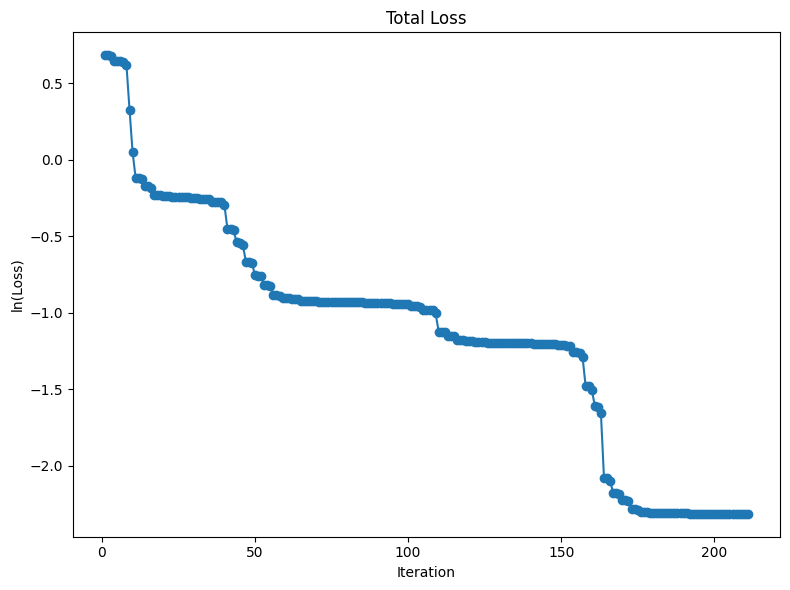

Final error: 0.09890367230400443
Displacement Thickness (δ*): 1.178966353247474
Momentum Thickness (θ): 5.210786211067924
Shape Factor (H): 0.22625498446727693
Wall Skin Friction Coefficient (C_f): 1.6309821573274679


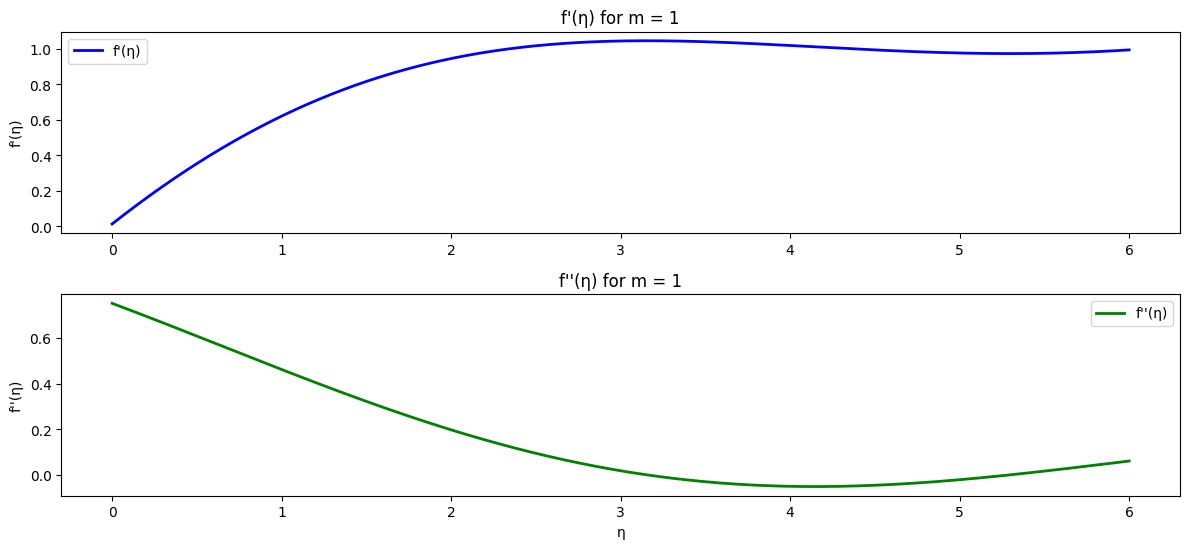

In [2]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim
import numpy as np
import matplotlib.pyplot as plt

# Creation of 1D array (representing data sampling)
np.random.seed(42)
torch.manual_seed(42)
eta = np.linspace(0, 6, 1000)[:, None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

# ODE parameters
m = 1  # this value of m can be changed and results for different wedge angles can be generated.
U_infinity = 1.0  # Free stream velocity

bc = eta[[0, -1]]
f_bc = np.array([[0], [1]])

eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

class PIELM(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1, bias=False)
        self.iter = 0
        self.Lbc = []
        self.Lpde = []

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        x = (x - eta_min) / (eta_max - eta_min)
        z = self.fc1(x)
        a = self.activation(z)
        f = self.fc2(a)
        return f

    def bc_loss(self, x, y):
        x1 = x[[0]]
        y1 = y[[0]]
        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1, g1, torch.ones([x1.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2, g2, torch.ones([x2.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        loss_bc1 = self.loss_function(f1, y1) + self.loss_function(f_etab1, torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2, y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc

    def PDE(self, x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)
        f_eta = autograd.grad(f3, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta2 = autograd.grad(f_eta, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta3 = autograd.grad(f_eta2, g3, torch.ones([g3.shape[0], 1]), create_graph=True)[0]
        pde = f_eta3 + ((m + 1) / 2) * f3 * f_eta2 + m * (1 - (f_eta)**2)
        loss_pde = self.loss_function(pde, torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde

    def loss(self, x, xb, yb):
        loss1 = self.bc_loss(xb, yb)
        loss2 = self.PDE(x)
        total_loss = abs(loss1) + abs(loss2)
        return total_loss

    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(eta, bc, f_bc)
        loss.backward()
        self.iter += 1

        # Log loss every iteration
        print(f'Iteration {self.iter}, Loss: {loss.item()}')

        return loss

    def test(self, x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_dd = autograd.grad(f_d, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()
        return pred_result, f_d, f_dd

# specification of network architecture
hidden_size = 50  # Increased hidden size

# creating an instance of NN class
pielm = PIELM()
pielm.fc1.weight.requires_grad = False
pielm.fc1.bias.requires_grad = False

# Increase max_iter for more iterations
max_iterations = 20000  # Increase this value as needed
optimizer = torch.optim.LBFGS(
    pielm.parameters(),
    lr=0.005,  # Reduced learning rate
    max_iter=max_iterations,
    tolerance_grad=1e-5,  # Increased tolerance to allow more iterations
    tolerance_change=1e-5,
    history_size=700,
    line_search_fn='strong_wolfe'
)

# Run the optimization
optimizer.step(pielm.closure)

# Print total iterations after optimization
print(f'Total iterations: {pielm.iter}')

Lbc_list = pielm.Lbc
Lpde_list = pielm.Lpde

# Plotting total loss
total_loss = [a + b for a, b in zip(Lbc_list, Lpde_list)]
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(total_loss) + 1), np.log(total_loss), marker='o')
plt.title('Total Loss')
plt.xlabel('Iteration')
plt.ylabel('ln(Loss)')
plt.tight_layout()
plt.show()

error = abs(total_loss[-1])
print(f'Final error: {error}')

# Testing the model and retrieving results
fp, fp_d, fp_dd = pielm.test(eta)

# Ensure fp is a 1D array
fp = fp.flatten()  # Flattening if it's 2D

# Calculate displacement thickness (δ*) and momentum thickness (θ)
def calculate_thicknesses(u_profile):
    # Assuming uniform free stream velocity
    y_values = np.linspace(0, 1, u_profile.shape[0])
    
    # Displacement thickness
    delta_star = np.trapz(1 - u_profile / U_infinity, y_values)
    
    # Momentum thickness
    theta = np.trapz(u_profile / U_infinity * (1 - u_profile / U_infinity), y_values)
    
    return np.abs(delta_star), np.abs(theta)

# Calculate thicknesses
delta_star, theta = calculate_thicknesses(fp)

# Calculate Shape Factor (H) and Wall Skin Friction Coefficient (C_f)
shape_factor = delta_star / theta if theta != 0 else np.inf  # Handle division by zero
C_f = 2 / (1 + shape_factor)  # Assuming u_tau / U_infinity = 1 for simplification

print(f'Displacement Thickness (δ*): {delta_star}')
print(f'Momentum Thickness (θ): {theta}')
print(f'Shape Factor (H): {shape_factor}')
print(f'Wall Skin Friction Coefficient (C_f): {C_f}')

# Creating individual plots for f, f', and f''
plt.figure(figsize=(12, 8))

# Convert eta to numpy for plotting
eta_np = eta.detach().numpy()

# Plotting f'(η)
plt.subplot(3, 1, 2)
plt.plot(eta_np, fp_d, label="f'(η)", color='blue', linewidth=2)
plt.title(f"f'(η) for m = {m}")
plt.ylabel("f'(η)")
plt.legend()

# Plotting f''(η)
plt.subplot(3, 1, 3)
plt.plot(eta_np, fp_dd, label="f''(η)", color='green', linewidth=2)
plt.title(f"f''(η) for m = {m}")
plt.ylabel("f''(η)")
plt.xlabel("η")
plt.legend()

plt.tight_layout()
plt.show()


### 
## Formulation A
####
#### For flat plate (beta=0)

Iteration 1, Loss: 0.9867227077484131
Iteration 2, Loss: 0.985331654548645
Iteration 3, Loss: 0.9734753370285034
Iteration 4, Loss: 0.972821831703186
Iteration 5, Loss: 0.9670608043670654
Iteration 6, Loss: 0.9213677048683167
Iteration 7, Loss: 0.9209447503089905
Iteration 8, Loss: 0.9190568923950195
Iteration 9, Loss: 0.900210976600647
Iteration 10, Loss: 0.8995973467826843
Iteration 11, Loss: 0.8941712975502014
Iteration 12, Loss: 0.8494447469711304
Iteration 13, Loss: 0.8488126993179321
Iteration 14, Loss: 0.8459898829460144
Iteration 15, Loss: 0.8176160454750061
Iteration 16, Loss: 0.8165841698646545
Iteration 17, Loss: 0.8074644804000854
Iteration 18, Loss: 0.7327927350997925
Iteration 19, Loss: 0.7318300008773804
Iteration 20, Loss: 0.7233203053474426
Iteration 21, Loss: 0.6535414457321167
Iteration 22, Loss: 0.6525143384933472
Iteration 23, Loss: 0.6479382514953613
Iteration 24, Loss: 0.6031392216682434
Iteration 25, Loss: 0.6022927165031433
Iteration 26, Loss: 0.598528563976287

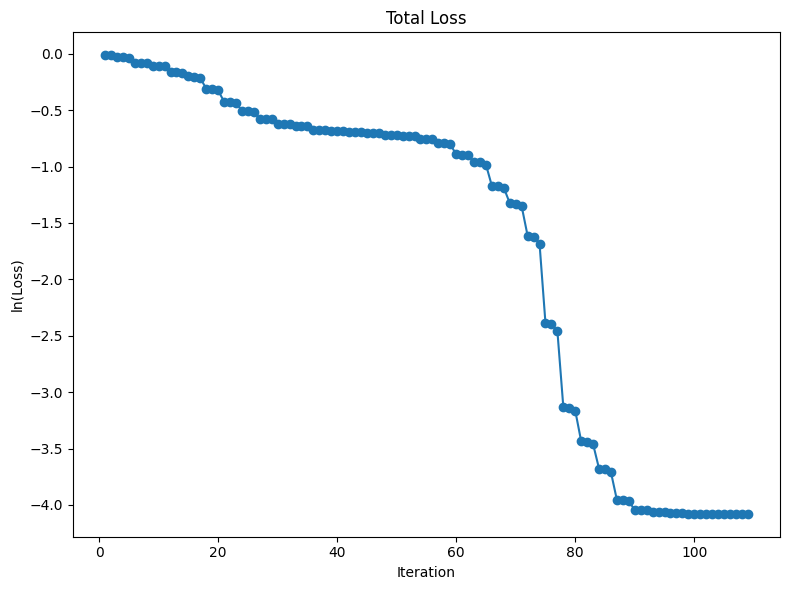

Final error: 0.016928590135648847
Displacement Thickness (δ*): 0.15791273558581326
Momentum Thickness (θ): 1.2501763702552366
Shape Factor (H): 0.12631236627322728
Wall Skin Friction Coefficient (C_f): 1.7757063314661579


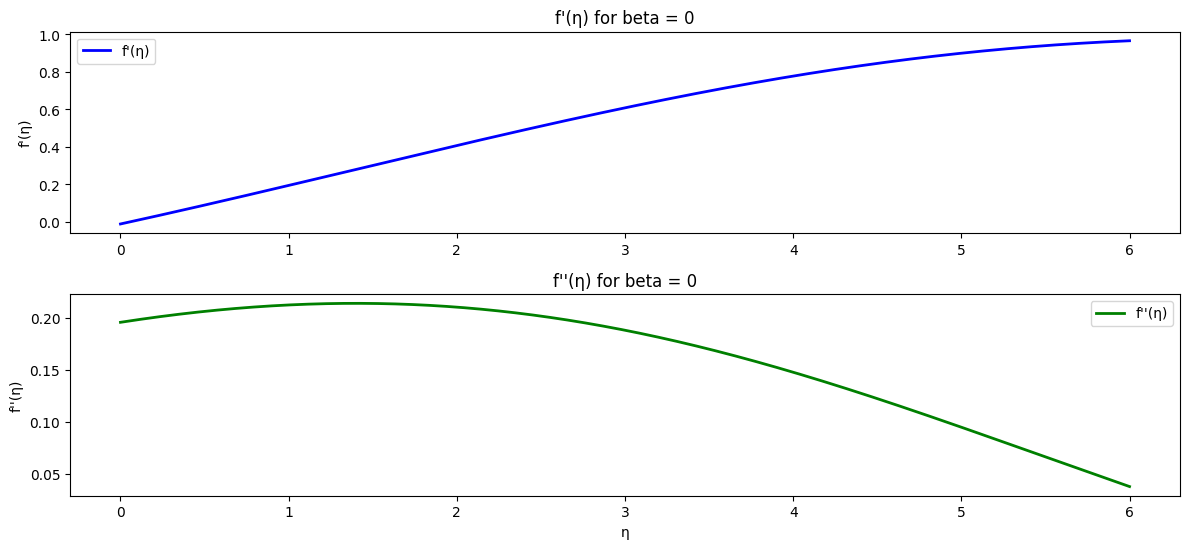

In [20]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# Creation of 1D array (representing data sampling)
np.random.seed(42)
torch.manual_seed(42)
eta = np.linspace(0, 6, 1000)[:, None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

# ODE parameters
beta = 0.0  # Set beta to 0 for a flat plate
U_infinity = 1.0  # Free stream velocity

bc = eta[[0, -1]]
f_bc = np.array([[0], [1]])

# Convert data to torch tensors
eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

class PIELM(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1, bias=False)
        self.iter = 0
        self.Lbc = []
        self.Lpde = []

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        # Normalizing the input to the range [0, 1]
        x = (x - eta_min) / (eta_max - eta_min)
        z = self.fc1(x)
        a = self.activation(z)
        f = self.fc2(a)
        return f

    def bc_loss(self, x, y):
        # First boundary condition
        x1 = x[[0]]
        y1 = y[[0]]
        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1, g1, torch.ones([x1.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        # Second boundary condition
        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2, g2, torch.ones([x2.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        # Loss for boundary conditions
        loss_bc1 = self.loss_function(f1, y1) + self.loss_function(f_etab1, torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2, y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc

    def PDE(self, x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)
        f_eta = autograd.grad(f3, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta2 = autograd.grad(f_eta, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta3 = autograd.grad(f_eta2, g3, torch.ones([g3.shape[0], 1]), create_graph=True)[0]

        # New PDE: f''' + f * f'' + beta * (1 - (f')^2) = 0
        pde = f_eta3 + f3 * f_eta2 + beta * (1 - f_eta**2)
        loss_pde = self.loss_function(pde, torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde

    def loss(self, x, xb, yb):
        loss1 = self.bc_loss(xb, yb)
        loss2 = self.PDE(x)
        total_loss = abs(loss1) + abs(loss2)
        return total_loss

    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(eta, bc, f_bc)
        loss.backward()
        self.iter += 1

        # Log loss every iteration
        print(f'Iteration {self.iter}, Loss: {loss.item()}')

        return loss

    def test(self, x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_dd = autograd.grad(f_d, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()
        return pred_result, f_d, f_dd

# Specification of network architecture
hidden_size = 50  # Increased hidden size

# Creating an instance of NN class
pielm = PIELM()
pielm.fc1.weight.requires_grad = False
pielm.fc1.bias.requires_grad = False

# Increase max_iter for more iterations
max_iterations = 20000  # Increase this value as needed
optimizer = torch.optim.LBFGS(
    pielm.parameters(),
    lr=0.005,  # Reduced learning rate
    max_iter=max_iterations,
    tolerance_grad=1e-5,  # Increased tolerance to allow more iterations
    tolerance_change=1e-5,
    history_size=700,
    line_search_fn='strong_wolfe'
)

# Run the optimization
optimizer.step(pielm.closure)

# Print total iterations after optimization
print(f'Total iterations: {pielm.iter}')

Lbc_list = pielm.Lbc
Lpde_list = pielm.Lpde

# Plotting total loss
total_loss = [a + b for a, b in zip(Lbc_list, Lpde_list)]
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(total_loss) + 1), np.log(total_loss), marker='o')
plt.title('Total Loss')
plt.xlabel('Iteration')
plt.ylabel('ln(Loss)')
plt.tight_layout()
plt.show()

error = abs(total_loss[-1])
print(f'Final error: {error}')

# Testing the model and retrieving results
fp, fp_d, fp_dd = pielm.test(eta)

# Ensure fp is a 1D array
fp = fp.flatten()  # Flattening if it's 2D

# Calculate displacement thickness (δ*) and momentum thickness (θ)
def calculate_thicknesses(u_profile):
    # Assuming uniform free stream velocity
    y_values = np.linspace(0, 1, u_profile.shape[0])
    
    # Displacement thickness
    delta_star = np.trapz(1 - u_profile / U_infinity, y_values)
    
    # Momentum thickness
    theta = np.trapz(u_profile / U_infinity * (1 - u_profile / U_infinity), y_values)
    
    return np.abs(delta_star), np.abs(theta)

# Calculate thicknesses
delta_star, theta = calculate_thicknesses(fp)

# Calculate Shape Factor (H) and Wall Skin Friction Coefficient (C_f)
shape_factor = delta_star / theta if theta != 0 else np.inf  # Handle division by zero
C_f = 2 / (1 + shape_factor)  # Assuming u_tau / U_infinity = 1 for simplification

print(f'Displacement Thickness (δ*): {delta_star}')
print(f'Momentum Thickness (θ): {theta}')
print(f'Shape Factor (H): {shape_factor}')
print(f'Wall Skin Friction Coefficient (C_f): {C_f}')

# Creating individual plots for f, f', and f''
plt.figure(figsize=(12, 8))

# Convert eta to numpy for plotting
eta_np = eta.detach().numpy()

# Plotting f'(η)
plt.subplot(3, 1, 2)
plt.plot(eta_np, fp_d, label="f'(η)", color='blue', linewidth=2)
plt.title("f'(η) for beta = 0")
plt.ylabel("f'(η)")
plt.legend()

# Plotting f''(η)
plt.subplot(3, 1, 3)
plt.plot(eta_np, fp_dd, label="f''(η)", color='green', linewidth=2)
plt.title("f''(η) for beta = 0")
plt.ylabel("f''(η)")
plt.xlabel("η")
plt.legend()

plt.tight_layout()
plt.show()


###
#### For stagnation point flow (beta=1)

Iteration 1, Loss: 1.9811828136444092
Iteration 2, Loss: 1.9797497987747192
Iteration 3, Loss: 1.9674869775772095
Iteration 4, Loss: 1.9076368808746338
Iteration 5, Loss: 1.9074654579162598
Iteration 6, Loss: 1.9059250354766846
Iteration 7, Loss: 1.8982113599777222
Iteration 8, Loss: 1.8556593656539917
Iteration 9, Loss: 1.3888744115829468
Iteration 10, Loss: 1.0519734621047974
Iteration 11, Loss: 0.8876234292984009
Iteration 12, Loss: 0.886658251285553
Iteration 13, Loss: 0.8823771476745605
Iteration 14, Loss: 0.842610776424408
Iteration 15, Loss: 0.8417810201644897
Iteration 16, Loss: 0.8346500396728516
Iteration 17, Loss: 0.7964138984680176
Iteration 18, Loss: 0.796249508857727
Iteration 19, Loss: 0.7955222129821777
Iteration 20, Loss: 0.7889786958694458
Iteration 21, Loss: 0.7889154553413391
Iteration 22, Loss: 0.788462221622467
Iteration 23, Loss: 0.7863569259643555
Iteration 24, Loss: 0.7862929105758667
Iteration 25, Loss: 0.7860057950019836
Iteration 26, Loss: 0.7831947207450867

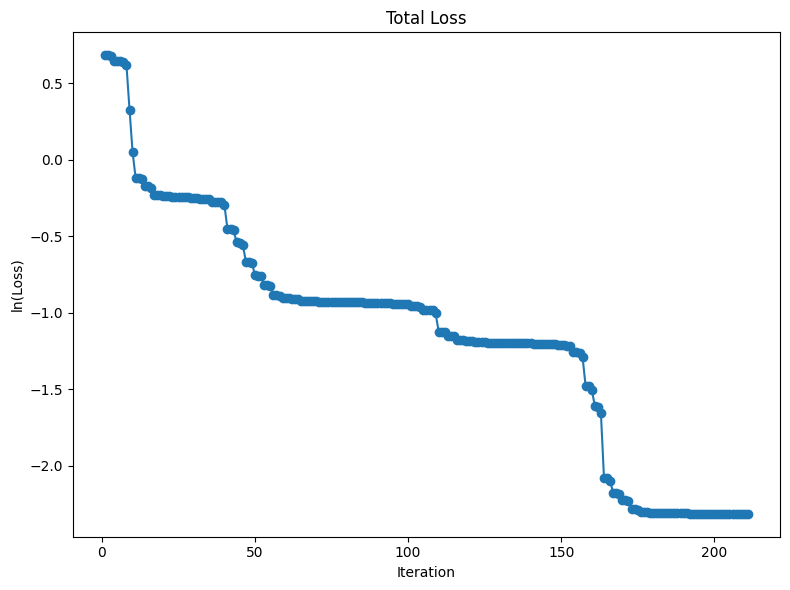

Final error: 0.09890367230400443
Displacement Thickness (δ*): 1.178966353247474
Momentum Thickness (θ): 5.210786211067924
Shape Factor (H): 0.22625498446727693
Wall Skin Friction Coefficient (C_f): 1.6309821573274679


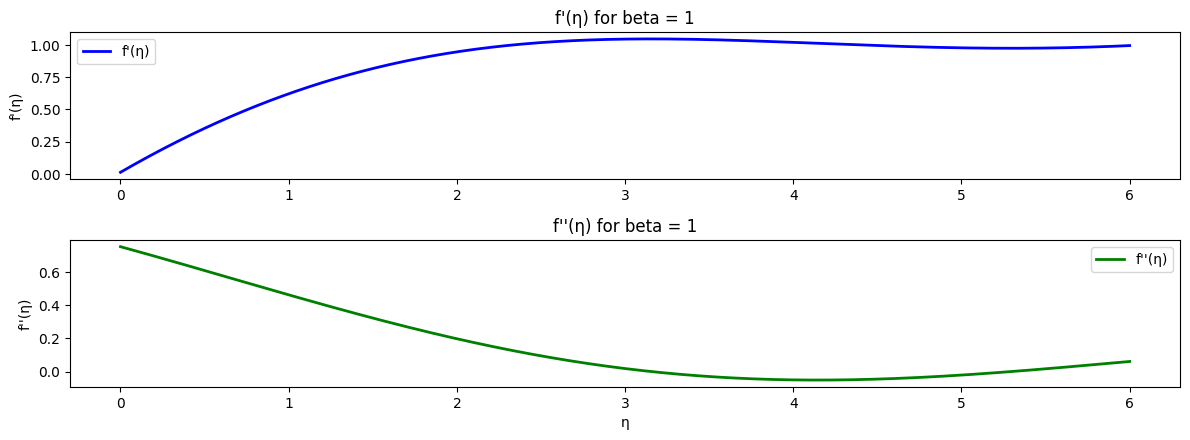

In [19]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# Creation of 1D array (representing data sampling)
np.random.seed(42)
torch.manual_seed(42)
eta = np.linspace(0, 6, 1000)[:, None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

# ODE parameters
beta = 1 # Set beta to 0 for a flat plate
U_infinity = 1.0  # Free stream velocity

bc = eta[[0, -1]]
f_bc = np.array([[0], [1]])

# Convert data to torch tensors
eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

class PIELM(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1, bias=False)
        self.iter = 0
        self.Lbc = []
        self.Lpde = []

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        # Normalizing the input to the range [0, 1]
        x = (x - eta_min) / (eta_max - eta_min)
        z = self.fc1(x)
        a = self.activation(z)
        f = self.fc2(a)
        return f

    def bc_loss(self, x, y):
        # First boundary condition
        x1 = x[[0]]
        y1 = y[[0]]
        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1, g1, torch.ones([x1.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        # Second boundary condition
        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2, g2, torch.ones([x2.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        # Loss for boundary conditions
        loss_bc1 = self.loss_function(f1, y1) + self.loss_function(f_etab1, torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2, y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc

    def PDE(self, x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)
        f_eta = autograd.grad(f3, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta2 = autograd.grad(f_eta, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta3 = autograd.grad(f_eta2, g3, torch.ones([g3.shape[0], 1]), create_graph=True)[0]

        # New PDE: f''' + f * f'' + beta * (1 - (f')^2) = 0
        pde = f_eta3 + f3 * f_eta2 + beta * (1 - f_eta**2)
        loss_pde = self.loss_function(pde, torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde

    def loss(self, x, xb, yb):
        loss1 = self.bc_loss(xb, yb)
        loss2 = self.PDE(x)
        total_loss = abs(loss1) + abs(loss2)
        return total_loss

    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(eta, bc, f_bc)
        loss.backward()
        self.iter += 1

        # Log loss every iteration
        print(f'Iteration {self.iter}, Loss: {loss.item()}')

        return loss

    def test(self, x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_dd = autograd.grad(f_d, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()
        return pred_result, f_d, f_dd

# Specification of network architecture
hidden_size = 50  # Increased hidden size

# Creating an instance of NN class
pielm = PIELM()
pielm.fc1.weight.requires_grad = False
pielm.fc1.bias.requires_grad = False

# Increase max_iter for more iterations
max_iterations = 20000  # Increase this value as needed
optimizer = torch.optim.LBFGS(
    pielm.parameters(),
    lr=0.005,  # Reduced learning rate
    max_iter=max_iterations,
    tolerance_grad=1e-5,  # Increased tolerance to allow more iterations
    tolerance_change=1e-5,
    history_size=700,
    line_search_fn='strong_wolfe'
)

# Run the optimization
optimizer.step(pielm.closure)

# Print total iterations after optimization
print(f'Total iterations: {pielm.iter}')

Lbc_list = pielm.Lbc
Lpde_list = pielm.Lpde

# Plotting total loss
total_loss = [a + b for a, b in zip(Lbc_list, Lpde_list)]
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(total_loss) + 1), np.log(total_loss), marker='o')
plt.title('Total Loss')
plt.xlabel('Iteration')
plt.ylabel('ln(Loss)')
plt.tight_layout()
plt.show()

error = abs(total_loss[-1])
print(f'Final error: {error}')

# Testing the model and retrieving results
fp, fp_d, fp_dd = pielm.test(eta)

# Ensure fp is a 1D array
fp = fp.flatten()  # Flattening if it's 2D

# Calculate displacement thickness (δ*) and momentum thickness (θ)
def calculate_thicknesses(u_profile):
    # Assuming uniform free stream velocity
    y_values = np.linspace(0, 1, u_profile.shape[0])
    
    # Displacement thickness
    delta_star = np.trapz(1 - u_profile / U_infinity, y_values)
    
    # Momentum thickness
    theta = np.trapz(u_profile / U_infinity * (1 - u_profile / U_infinity), y_values)
    
    return np.abs(delta_star), np.abs(theta)

# Calculate thicknesses
delta_star, theta = calculate_thicknesses(fp)

# Calculate Shape Factor (H) and Wall Skin Friction Coefficient (C_f)
shape_factor = delta_star / theta if theta != 0 else np.inf  # Handle division by zero
C_f = 2 / (1 + shape_factor)  # Assuming u_tau / U_infinity = 1 for simplification

print(f'Displacement Thickness (δ*): {delta_star}')
print(f'Momentum Thickness (θ): {theta}')
print(f'Shape Factor (H): {shape_factor}')
print(f'Wall Skin Friction Coefficient (C_f): {C_f}')

# Creating individual plots for f, f', and f''
plt.figure(figsize=(12, 8))

# Convert eta to numpy for plotting
eta_np = eta.detach().numpy()

# Plotting f'(η)
plt.subplot(4, 1, 2)
plt.plot(eta_np, fp_d, label="f'(η)", color='blue', linewidth=2)
plt.title("f'(η) for beta = 1")
plt.ylabel("f'(η)")
plt.legend()

# Plotting f''(η)
plt.subplot(4, 1, 3)
plt.plot(eta_np, fp_dd, label="f''(η)", color='green', linewidth=2)
plt.title("f''(η) for beta = 1")
plt.ylabel("f''(η)")
plt.xlabel("η")
plt.legend()

plt.tight_layout()
plt.show()
